In [2]:
%%capture
!pip install pybamm
!pip install import-ipynb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
current_dir = os.getcwd()
new_dir = '/content/drive/MyDrive/Colab Notebooks/MeaTEC_Project'  # Replace with desired directory
os.chdir(new_dir)
print(f"Current working directory: {os.getcwd()}")
files_in_directory = os.listdir(current_dir) # List all files in the current directory

Current working directory: /content/drive/MyDrive/Colab Notebooks/MeaTEC_Project


In [12]:
import pybamm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings
import import_ipynb
import DATA_Extraction_from_Liiondb
warnings.filterwarnings('ignore')

In [6]:
### HPPC DATA
df_HPPC = pd.read_csv('951_HPPC.csv')
df_HPPC.drop(index=0, inplace=True)
df_HPPC[['Voltage','Current']] = df_HPPC[['Voltage','Current']].astype(float)
#df_HPPC = df_HPPC[df_HPPC['Current'] != 0]
df_HPPC['Timeseries'] = np.arange(len(df_HPPC))*0.1
df_HPPC['Current']=df_HPPC['Current']*-1

#### Experimental Data ####
drive_HPPC=df_HPPC[['Timeseries','Current']]
drive_HPPC = drive_HPPC.to_numpy()

In [7]:
Graphite_HOCVs_filtered,LFP_HOCVs,LFP_Paper_tags=DATA_Extraction_from_Liiondb.Graphite_HOCVs_filtered, DATA_Extraction_from_Liiondb.LFP_HOCVs,DATA_Extraction_from_Liiondb.LFP_Paper_tags

def half_cell_ocv_LFP_Kashkooli(x):
    U = 3.382 + 0.00470*x + 1.627*np.exp(-81.163*x**1.0138) + 7.6445E-8*np.exp(25.36*x**2.469) - 8.4410E-8*np.exp(25.262*x**2.478)
    return U

def halfcellocvThorat2011(x):
    U1 = 2.567462 + 57.69*(1-np.tanh(100*x + 2.9163927))
    U2 = 0.442953*np.arctan(-65.41928*x + 64.89741)
    U3 = 0.097237*np.arctan(-160.9058*x + 154.590)
    U = U1 + U2 + U3
    return U

Sel_Pos_OCV=[half_cell_ocv_LFP_Kashkooli,halfcellocvThorat2011]
Sel_Neg_OCV=Graphite_HOCVs_filtered[:-1] #[Ecker2015, Prada2012_1, Prada2012_2]

Final_Pos_OCV=Sel_Pos_OCV[1]

Final_Neg_OCV=Sel_Neg_OCV[2]
nocp_data=Final_Neg_OCV

In [16]:
def rmse_objective(x, model, experiment, df_exp, params_base, param_names,param_modes):
    """Dynamic objective function for any number of parameters"""
    params = params_base.copy()

    # Update all parameters dynamically
    for i, (name, mode) in enumerate(zip(param_names, param_modes)):
        if mode == 'log':
            params[name] = 10 ** x[i]
        else:
            params[name] = x[i]


    try:
        sim = pybamm.Simulation(model, parameter_values=params, experiment=experiment)
        sol = sim.solve()

        sim_time = sol["Time [s]"].data
        sim_voltage = sol["Terminal voltage [V]"].data

        exp_time = np.sort(df_exp['Timeseries'].values)
        exp_voltage = df_exp['Voltage'].values[np.argsort(df_exp['Timeseries'].values)]

        f = interp1d(exp_time, exp_voltage,
             kind='linear', bounds_error=False, fill_value='extrapolate')
        interpolated_voltage = f(sim_time)

        rmse = np.sqrt(np.mean((sim_voltage - interpolated_voltage)**2))
        return rmse

    except Exception as e:
        return 1e6


In [1]:
def two_stage_optimizer_hybrid(
    x0,
    bounds,
    model,
    experiment,
    df_exp,
    params_base,
    param_names,
    param_modes,
):
    '''log_dict = {"stage": [], "method": [], "rmse": []}
    for name in param_names:
        log_dict[name] = []
        log_dict[f"log10({name})"] = []'''

    best_rmse = np.inf
    best_result = None

    # ============================
    # Stage 1 — global
    # ============================
    print("\n=== Stage 1: Powell (hybrid) ===")

    res1 = minimize(
        rmse_objective,
        x0,
        args=(model, experiment, df_exp, params_base,
              param_names, param_modes),
        method="Powell",
        bounds=bounds,
        options={"maxiter": 10, "ftol": 1e-3, "disp": True}
    )

    if np.isfinite(res1.fun):
        best_result = res1
        best_rmse = res1.fun

    # ============================
    # Stage 2 — local
    # ============================
    print("\n=== Stage 2: L-BFGS-B (hybrid) ===")

    res2 = minimize(
        rmse_objective,
        best_result.x,
        args=(model, experiment, df_exp, params_base,
              param_names, param_modes),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 50, "ftol": 1e-6, "disp": True}
    )
    #pd.DataFrame(log_dict)

    if np.isfinite(res2.fun) and res2.fun < best_rmse:
        best_result = res2
        best_rmse = res2.fun

    return best_result


In [18]:
PARAM_SET = {
    'Negative particle diffusivity [m2.s-1]': (3.0e-15,3.5e-15),
    'Positive particle diffusivity [m2.s-1]': (5.9e-19,5.9e-16),
    #'Electrolyte diffusivity [m2.s-1]':(2e-11,2e-8),
    #'Negative particle radius [m]':(4.8e-6,5.2e-6),
    #'Positive particle radius [m]':(2e-8,7e-8),
    #'Positive electrode thickness [m]': (6e-5,11e-5),
    #'Negative electrode thickness [m]': (3.39e-5,3.41e-5),
    'Electrode width [m]': (0.084, 0.085),
    #'Initial concentration in electrolyte [mol.m-3]':(1000,1500),
    #'Initial concentration in positive electrode [mol.m-3]':(100,138),
    #'Initial concentration in negative electrode [mol.m-3]':(24500,25000),
}

LOG_PARAMS = [
    'Negative particle diffusivity [m2.s-1]',
    'Positive particle diffusivity [m2.s-1]',
    #'Electrolyte diffusivity [m2.s-1]',
    #'Negative particle radius [m]',
    #'Positive particle radius [m]',
    #'Positive electrode thickness [m]',
    #'Negative electrode thickness [m]'
]

LIN_PARAMS = [
    'Electrode width [m]',
    #'Initial concentration in electrolyte [mol.m-3]',
    #'Initial concentration in positive electrode [mol.m-3]',
    #'Initial concentration in negative electrode [mol.m-3]'
]

# Extract parameter names and bounds

param_names = LOG_PARAMS + LIN_PARAMS
param_modes = ['log'] * len(LOG_PARAMS) + ['linear'] * len(LIN_PARAMS)

bounds_hybrid = []

for name, mode in zip(param_names, param_modes):
    low, high = PARAM_SET[name]
    if mode == 'log':
        bounds_hybrid.append((np.log10(low), np.log10(high)))
    else:
        bounds_hybrid.append((low, high))

n_params = len(param_names)

print(f"Optimizing {n_params} parameters: {param_names}")
print(f"Bounds: {bounds_hybrid}")

# Initial setup
model = pybamm.lithium_ion.SPMe()
params_base = pybamm.ParameterValues("Prada2013")

params_base.update({
    "Electrode width [m]": 0.0845,
    "Electrode height [m]": 0.645,
    "Number of electrodes connected in parallel to make a cell": 4,
    "Nominal cell capacity [A.h]": 2.5,
    "Current function [A]": 2.5,
    "Positive electrode OCP [V]": Final_Pos_OCV,
    "Negative electrode OCP [V]": ("half_cell_Negative", np.array(nocp_data))
})

experiment = pybamm.Experiment([pybamm.step.current(drive_HPPC)])

# Initial values from params_base

x0_hybrid = []

for name, mode in zip(param_names, param_modes):
    val = params_base[name]
    if mode == 'log':
        x0_hybrid.append(np.log10(val))
    else:
        x0_hybrid.append(val)

x0_hybrid = np.array(x0_hybrid)

# Baseline simulation
print("\n Running baseline simulation...")
sim = pybamm.Simulation(model, parameter_values=params_base, experiment=experiment)
sol_base = sim.solve()

baseline_rmse = rmse_objective(
    x0_hybrid,
    model,
    experiment,
    df_HPPC,
    params_base,
    param_names,
    param_modes
)

print(f"Baseline RMSE: {baseline_rmse:.4f} V")

Optimizing 3 parameters: ['Negative particle diffusivity [m2.s-1]', 'Positive particle diffusivity [m2.s-1]', 'Electrode width [m]']
Bounds: [(np.float64(-14.522878745280337), np.float64(-14.455931955649724)), (np.float64(-18.229147988357855), np.float64(-15.229147988357855)), (0.084, 0.085)]

 Running baseline simulation...
Baseline RMSE: 0.1249 V


In [ ]:
# === PARAMETER OPTIMIZATION ===
# Just add parameter names and bounds here!


best_result = two_stage_optimizer_hybrid(
    x0=x0_hybrid,
    bounds=bounds_hybrid,
    model=model,
    experiment=experiment,
    df_exp=df_HPPC,
    params_base=params_base,
    param_names=param_names,
    param_modes=param_modes,
)

best_x = best_result.x

params_opt = params_base.copy()
for i, (name, mode) in enumerate(zip(param_names, param_modes)):
    if mode == 'log':
        params_opt[name] = 10 ** best_x[i]
    else:
        params_opt[name] = best_x[i]

print("\n" + "="*100)
print(" HYBRID OPTIMIZATION RESULTS")
print("="*100)

for i, (name, mode) in enumerate(zip(param_names, param_modes)):
    init_val = params_base[name]

    if mode == "log":
        opt_val = 10 ** best_x[i]
        log_val = best_x[i]
    else:
        opt_val = best_x[i]
        log_val = np.log10(opt_val)

    change = (opt_val - init_val) / init_val * 100

    print(
        f"{name:<40}: "
        f"{opt_val:.3e} "
        f"(init_val={init_val:+.3f}, Δ{change:+6.1f}%)"
    )
best_rmse = best_result.fun
print(f"\n Best RMSE: {best_rmse:.4f} V")
print(f" Improvement: {((baseline_rmse - best_rmse)/baseline_rmse*100):+.1f}%")


=== Stage 1: Powell (hybrid) ===


## Plotting final results


 Running optimised parameters with HPPC data...


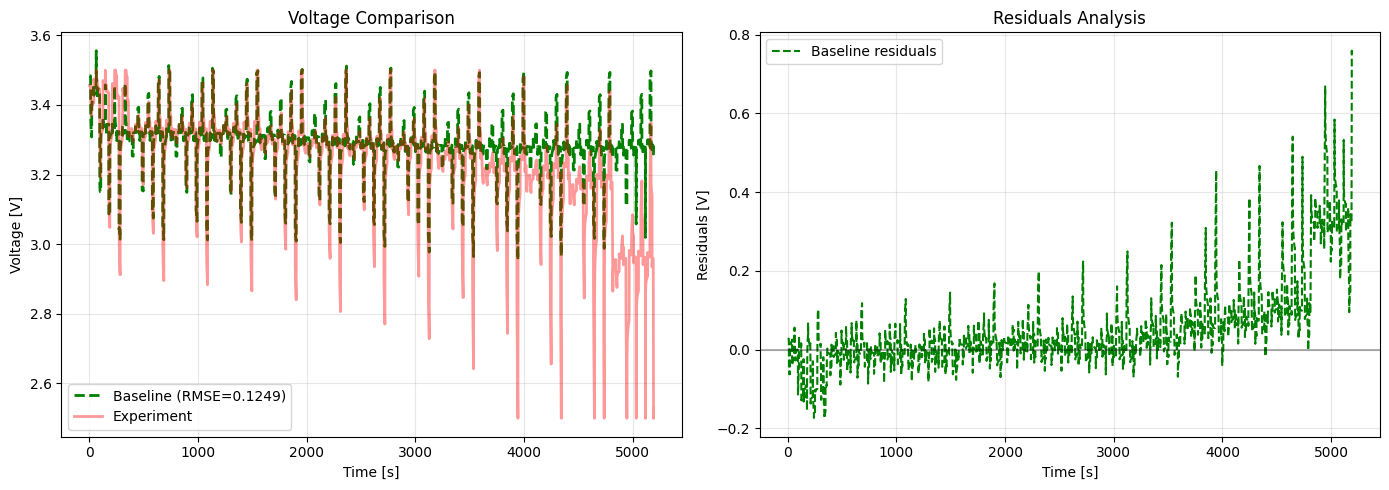

In [21]:
print("\n Running optimised parameters with HPPC data...")
#sim_opt = pybamm.Simulation(model, parameter_values=params_opt, experiment=experiment)
#sol_opt = sim_opt.solve()


# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(sol_base["Time [s]"].data, sol_base["Terminal voltage [V]"].data, 'g--', lw=2, label=f'Baseline (RMSE={baseline_rmse:.4f})')
#plt.plot(sol_opt["Time [s]"].data, sol_opt["Terminal voltage [V]"].data, 'b-', lw=2, label=f'Optimized (RMSE={best_rmse:.4f})')
plt.plot(df_HPPC['Timeseries'], df_HPPC['Voltage'], 'r', lw=2, alpha=0.4, label='Experiment')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Voltage Comparison')

plt.subplot(1, 2, 2)
exp_time = np.sort(df_HPPC['Timeseries'].values)
residual_base = np.interp(exp_time, sol_base["Time [s]"].data, sol_base["Terminal voltage [V]"].data) - df_HPPC['Voltage'].values[np.argsort(df_HPPC['Timeseries'])]
#residual_opt = np.interp(exp_time, sol_opt["Time [s]"].data, sol_opt["Terminal voltage [V]"].data) - df_HPPC['Voltage'].values[np.argsort(df_HPPC['Timeseries'])]
plt.plot(exp_time, residual_base, 'g--', label='Baseline residuals')
#plt.plot(exp_time, residual_opt, 'b-', label='Optimized residuals')
plt.axhline(0, color='k', alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('Residuals [V]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Residuals Analysis')

plt.tight_layout()
plt.show()


# Validation with WLTP Drive cycle

In [ ]:
### Drive cycle DATA
df_WLTP = pd.read_csv('959_WLTP95a.csv')
df_WLTP.drop(index=0, inplace=True)
df_WLTP[['Voltage','Current']] = df_WLTP[['Voltage','Current']].astype(float)
df_WLTP['Timeseries'] = np.arange(len(df_WLTP))*1
df_WLTP['Current']=df_WLTP['Current']*-1

#### Experimental Data ####
drive_WLTP=df_WLTP[['Timeseries','Current']]
drive_WLTP = drive_WLTP.to_numpy()

In [ ]:
experiment_WLTP = pybamm.Experiment([pybamm.step.current(drive_WLTP)])

In [ ]:
print("\n Running final validation...")

WLTP_rmse = rmse_objective(
    best_x,
    model,
    experiment_WLTP,
    df_WLTP,
    params_opt,
    param_names,
    param_modes
)

print(f"WLTP_rmse: {WLTP_rmse:.4f} V")

sim_opt = pybamm.Simulation(model, parameter_values=params_opt, experiment=experiment_WLTP)
sol_opt = sim_opt.solve()

# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(sol_opt["Time [s]"].data, sol_opt["Terminal voltage [V]"].data, 'b-', lw=2, label=f'Optimized (RMSE={WLTP_rmse:.4f})')
plt.plot(df_WLTP['Timeseries'], df_WLTP['Voltage'], 'r', lw=2, alpha=0.4, label='Experiment')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Voltage Comparison')

plt.subplot(1, 2, 2)
exp_time = np.sort(df_WLTP['Timeseries'].values)
residual_opt = np.interp(exp_time, sol_opt["Time [s]"].data, sol_opt["Terminal voltage [V]"].data) - df_WLTP['Voltage'].values[np.argsort(df_WLTP['Timeseries'])]
plt.plot(exp_time, residual_opt, 'b-', label='Optimized residuals')
plt.axhline(0, color='k', alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('Residuals [V]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Residuals Analysis')

plt.tight_layout()
plt.show()
